In [1]:
%matplotlib inline
import slug
import os
import glob
import h5py

import numpy as np

import matplotlib.pyplot as plt

from kungpao import io
from kungpao.display import display_single, IMG_CMAP, SEG_CMAP

from astropy.io import fits
from astropy import wcs
from astropy.table import Table, Column


from IPython.display import clear_output

In [2]:
ra_cen = 129.603676                  # ra of object
dec_cen = -1.606419                  # dec of object
redshift = 0.052043
fits_data = fits.open('./Images/cut_Dragonfly_r.fits')

In [3]:
if not os.path.isdir('HDF5'):
    os.mkdir('HDF5')
f = h5py.File('./HDF5/Dragonfly_test.h5','w')
dt = h5py.special_dtype(vlen=str)

info = f.create_dataset('info', (10,2), dtype='S20')
info[0] = 'edition', 'Dragonfly'
info[1] = 'ra', ra_cen
info[2] = 'dec', dec_cen
info[3] = 'size (pix)', str([fits_data[0].shape[0], fits_data[0].shape[1]])
info[4] = 'redshift', redshift
g1 = f.create_group('Image')
g1.create_dataset('image', data=fits_data[0].data)
g1.create_dataset('image_header', data=fits_data[0].header.tostring(), dtype=dt)
f.close()

In [4]:
f = h5py.File('./HDF5/Dragonfly_test.h5', 'r')
print(f['info'][:])
f.close()

[['edition' 'Dragonfly']
 ['ra' '129.603676']
 ['dec' '-1.606419']
 ['size (pix)' '[120, 120]']
 ['redshift' '0.052043']
 ['' '']
 ['' '']
 ['' '']
 ['' '']
 ['' '']]


### 1-D profile

('At redshift', 0.052043, ', 1 arcsec =', 1.0149765914580582, 'kpc')
# Detect 52 objects


# Detect 69 objects
# Mean Sky / RMS Sky = 1351.69556 /    2.72123


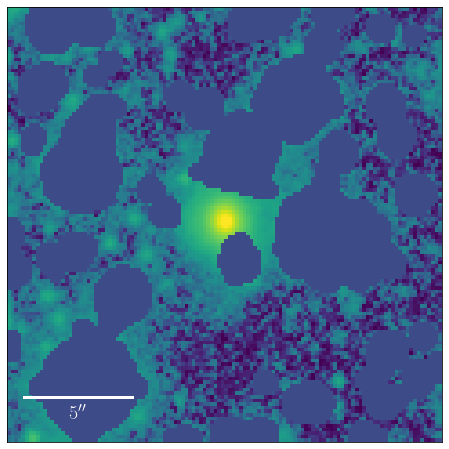

In [5]:
prefix = 'Dragonfly_test'

f = h5py.File('./HDF5/Dragonfly_test.h5', 'r+')
img = f['Image']['image'].value
w = wcs.WCS(f['Image']['image_header'].value)
g4 = f.create_group('Mask')
g5 = f.create_group('MaskedImage')

# phys_size
redshift = float(f['info'][4,1])
phys_size = slug.phys_size(redshift)

# extract obj
data = img
data = data.byteswap().newbyteorder()
objects, segmap = slug.extract_obj(
    data,
    b=15,
    f=3,
    sigma=3,
    pixel_scale=slug.Dragonfly_pixel_scale,
    deblend_cont=0.0001,
    deblend_nthresh=128,
    show_fig=False)

# make mask
seg_mask = slug.make_binary_mask(data, w, segmap, radius=1.0, show_fig=False, threshold=0.01, gaia=True)

# evaluate_sky
bkg_global = slug.evaluate_sky_dragonfly(data, b=15, f=3, sigma=1.5, radius=1.0, 
                                         threshold=0.005, show_fig=False, show_hist=False)

f['info'][5] = 'global bkg', bkg_global.globalback
f['info'][6] = 'global rms', bkg_global.globalrms

g4.create_dataset('mask', data=seg_mask)
HSC_mask = fits.open('./Data/msk_rebin_HSC_for_Dragonfly.fits')[0].data
g4.create_dataset('HSCmask', data=HSC_mask)
g5.create_dataset('maskedimage', data=(data-bkg_global.globalback)*(~seg_mask))
g5.create_dataset('HSCmaskedimage', data=(data-bkg_global.globalback)*(~HSC_mask))

# Save image and mask
if not os.path.isdir('Images'):
    os.mkdir('Images')
if not os.path.isdir('Masks'):
    os.mkdir('Masks')
img_fits = './Images/' + prefix + '_img.fits'
msk_fits = './Masks/' + prefix + '_msk.fits'

io.save_to_fits((data-bkg_global.globalback), img_fits, wcs=w)
io.save_to_fits(seg_mask.astype('uint8'), msk_fits, wcs=w)

display_single((data-bkg_global.globalback)*(~seg_mask))
plt.show(block=False)

In [6]:
# Run ELLIPSE
phys_size = slug.phys_size(redshift)
iraf_path = '/Users/jiaxuanli/Research/slug/slug/iraf/macosx/'
ell_free, ell_fix = slug.run_SBP(
    img_fits,
    './Data/msk_rebin_HSC_for_Dragonfly.fits',
    slug.Dragonfly_pixel_scale,
    phys_size,
    iraf_path,
    step=0.2,
    sma_ini=5.0,
    sma_max=80.0,
    n_clip=1,
    low_clip=3.0,
    upp_clip=3.0,
    outPre=prefix)
f['info'][7] = 'mean_e', ell_fix['ell'][10]
f['info'][8] = 'mean_pa', ell_fix['pa'][10]
f.create_dataset('ell_fix', data=ell_fix)
f.create_dataset('ell_free', data=ell_free)

f.close()

('At redshift', 0.052043, ', 1 arcsec =', 1.0149765914580582, 'kpc')
./Data/msk_rebin_HSC_for_Dragonfly.fits -> temp_URYQY.fits.pl
./Data/msk_rebin_HSC_for_Dragonfly.fits -> temp_URYQY.pl
----------------------------------------------------------------------------------------------------
###      galX, galY :  60 60
###      galR :  20.0
###      iniSma, maxSma :  5.0 80.0
###      Stage :  2
###      Step :  0.2
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : ./Images/Dragonfly_test_img.fits
###      Input Image   : temp_URYQY.fits
###      Output Binary : ./Images/Dragonfly_test_img_ellip_2.bin
------------------------------

In [7]:
f = h5py.File('./HDF5/Dragonfly_test.h5', 'r')
slug.h5_print_attrs(f)
print(f['info'].value)
f.close()

Image
Image/image
Image/image_header
Mask
Mask/HSCmask
Mask/mask
MaskedImage
MaskedImage/HSCmaskedimage
MaskedImage/maskedimage
ell_fix
ell_free
info
[['edition' 'Dragonfly']
 ['ra' '129.603676']
 ['dec' '-1.606419']
 ['size (pix)' '[120, 120]']
 ['redshift' '0.052043']
 ['global bkg' '1351.69555664']
 ['global rms' '2.72122645378']
 ['mean_e' '0.14']
 ['mean_pa' '26.57']
 ['' '']]


In [8]:
f = h5py.File('./HDF5/Dragonfly_test.h5', 'r')

bkgval_header = float(fits.open('./Images/coadd_SloanR.fits')[0].header['BACKVAL'])
off_set = bkgval_header - float(f['info'].value[5][1])

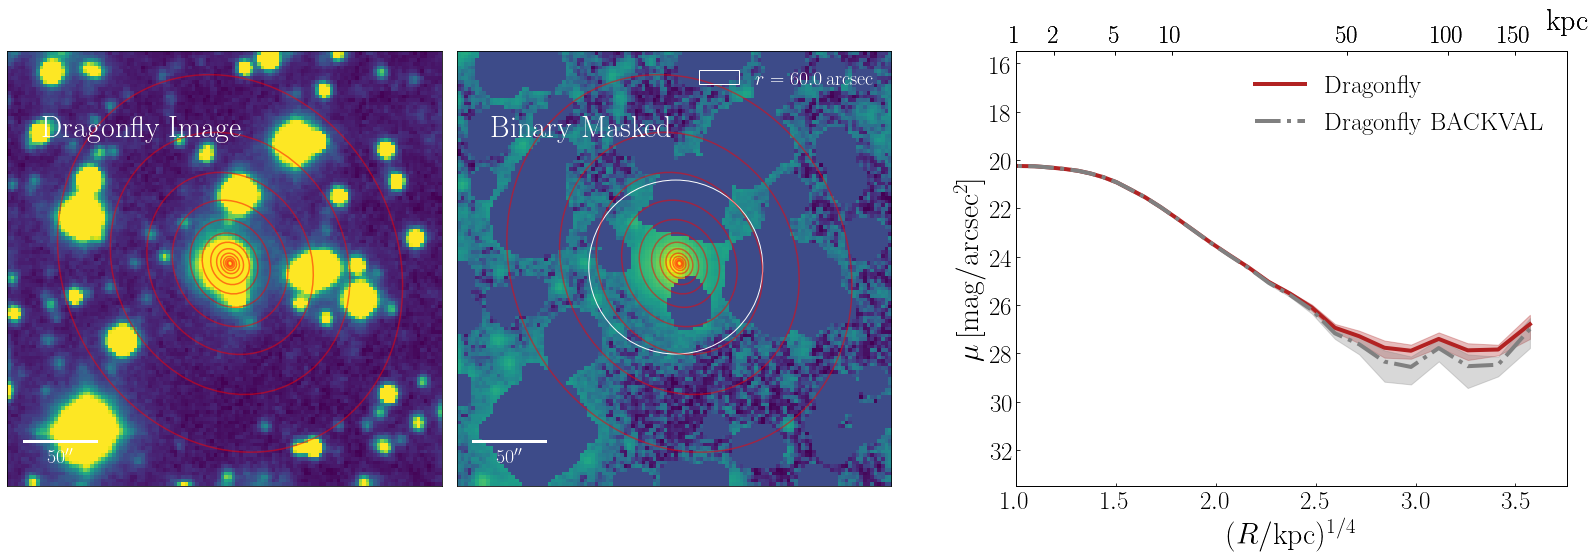

In [9]:
ellipse_fix = f['ell_fix'].value
img = f['Image']['image'].value
masked_img = f['MaskedImage']['maskedimage'].value

fig = plt.figure(figsize=(28, 8))
grid = plt.GridSpec(1, 14, wspace=0.1, hspace=0.1)

ax1 = fig.add_subplot(grid[0, 0:4])
ax1 = slug.display_isophote(
    img,
    ellipse_fix,
    slug.Dragonfly_pixel_scale,
    text='Dragonfly\ Image',
    ax=ax1)

ax2 = fig.add_subplot(grid[0, 4:8])
ax2 = slug.display_isophote(
    masked_img,
    ellipse_fix,
    slug.Dragonfly_pixel_scale,
    text='Binary\ Masked',
    ax=ax2,
    circle=60)

ax3 = fig.add_subplot(grid[0, 9:])
ax3.tick_params(direction='in')

slug.SBP_single(ellipse_fix, redshift, slug.Dragonfly_pixel_scale, slug.Dragonfly_zeropoint_r, ax=ax3,
    physical_unit=True, x_max=(200**0.25), vertical_line=False, show_dots=False, linecolor='firebrick',
    linestyle='-', label="Dragonfly")
slug.SBP_single(ellipse_fix, redshift, slug.Dragonfly_pixel_scale, slug.Dragonfly_zeropoint_r, ax=ax3, offset=-off_set,
    physical_unit=True, x_max=(200**0.25), vertical_line=False, show_dots=False, linecolor='gray',
    linestyle='-.', label="Dragonfly\ BACKVAL")

plt.ylim(15.5, 33.5)
#plt.vlines((100 * 0.168)**0.25, 15.5, 32.5, linestyle='-.', label='60 arcsec')
ax3.invert_yaxis()
plt.subplots_adjust(hspace=0.)
#f.close()
#plt.savefig('./Figures/' + prefix + '.png', dpi=100, bbox_inches='tight')